## Import Library

In [1]:
!pip install optuna

In [2]:
!pip install timeout-decorator

  Preparing metadata (setup.py) ... done
  Created wheel for timeout-decorator: filename=timeout_decorator-0.5.0-py3-none-any.whl size=5007 sha256=a7c18f597ad48744648bd010b7d0e754ed42269f862377cef9bb1ef1d7b09809
  Stored in directory: /root/.cache/pip/wheels/aa/cd/d1/51736c6b95846b2613a520ce146a8f305c4016a987bc9faec7
Successfully built timeout-decorator


In [3]:
import os

cpu_count = os.cpu_count()
print(f"Number of CPU cores: {cpu_count}")

Number of CPU cores: 4


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from collections import Counter
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import optuna
import timeout_decorator
from timeout_decorator.timeout_decorator import TimeoutError
import joblib

## Import Dataset

In [5]:
df = pd.read_csv('/kaggle/input/preprocessed-fake-reviews-dataset/preprocessed-fake-reviews-dataset.csv')

In [6]:
df.head()

,rating,label,text_,cleaned_text,category_Books_5,category_Clothing_Shoes_and_Jewelry_5,category_Electronics_5,category_Home_and_Kitchen_5,category_Kindle_Store_5,category_Movies_and_TV_5,category_Pet_Supplies_5,category_Sports_and_Outdoors_5,category_Tools_and_Home_Improvement_5,category_Toys_and_Games_5
0,5.0,1,"Love this! Well made, sturdy, and very comfor...",Love this Well made sturdy and very comfortab...,False,False,False,True,False,False,False,False,False,False
1,5.0,1,"love it, a great upgrade from the original. I...",love it a great upgrade from the original Ive...,False,False,False,True,False,False,False,False,False,False
2,5.0,1,This pillow saved my back. I love the look and...,This pillow saved my back I love the look and ...,False,False,False,True,False,False,False,False,False,False
3,1.0,1,"Missing information on how to use it, but it i...",Missing information on how to use it but it is...,False,False,False,True,False,False,False,False,False,False
4,5.0,1,Very nice set. Good quality. We have had the s...,Very nice set Good quality We have had the set...,False,False,False,True,False,False,False,False,False,False


In [7]:
df.isnull().sum()

rating                                   0
label                                    0
text_                                    0
cleaned_text                             1
category_Books_5                         0
category_Clothing_Shoes_and_Jewelry_5    0
category_Electronics_5                   0
category_Home_and_Kitchen_5              0
category_Kindle_Store_5                  0
category_Movies_and_TV_5                 0
category_Pet_Supplies_5                  0
category_Sports_and_Outdoors_5           0
category_Tools_and_Home_Improvement_5    0
category_Toys_and_Games_5                0
dtype: int64

In [8]:
df['cleaned_text'] = df['cleaned_text'].fillna("")

In [9]:
df.isnull().sum()

rating                                   0
label                                    0
text_                                    0
cleaned_text                             0
category_Books_5                         0
category_Clothing_Shoes_and_Jewelry_5    0
category_Electronics_5                   0
category_Home_and_Kitchen_5              0
category_Kindle_Store_5                  0
category_Movies_and_TV_5                 0
category_Pet_Supplies_5                  0
category_Sports_and_Outdoors_5           0
category_Tools_and_Home_Improvement_5    0
category_Toys_and_Games_5                0
dtype: int64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40432 entries, 0 to 40431
Data columns (total 14 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   rating                                 40432 non-null  float64
 1   label                                  40432 non-null  int64  
 2   text_                                  40432 non-null  object 
 3   cleaned_text                           40432 non-null  object 
 4   category_Books_5                       40432 non-null  bool   
 5   category_Clothing_Shoes_and_Jewelry_5  40432 non-null  bool   
 6   category_Electronics_5                 40432 non-null  bool   
 7   category_Home_and_Kitchen_5            40432 non-null  bool   
 8   category_Kindle_Store_5                40432 non-null  bool   
 9   category_Movies_and_TV_5               40432 non-null  bool   
 10  category_Pet_Supplies_5                40432 non-null  bool   
 11  ca

In [11]:
df.describe()

,rating,label
count,40432.000000,40432.000000
mean,4.256579,0.500000
std,1.144354,0.500006
min,1.000000,0.000000
25%,4.000000,0.000000
50%,5.000000,0.500000
75%,5.000000,1.000000
max,5.000000,1.000000


## Data Splitting

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df, df['label'], test_size=0.2, random_state=42, stratify=df['label'])

In [13]:
train_label_counts = y_train.value_counts()
test_label_counts = y_test.value_counts()

print("Jumlah Real Review Train (0):", train_label_counts[0])
print("Jumlah Fake Review Train (1):", train_label_counts[1])
print("Jumlah Real Review Test (0):", test_label_counts[0])
print("Jumlah Fake Review Test (1):", test_label_counts[1])

Jumlah Real Review Train (0): 16172
Jumlah Fake Review Train (1): 16173
Jumlah Real Review Test (0): 4044
Jumlah Fake Review Test (1): 4043


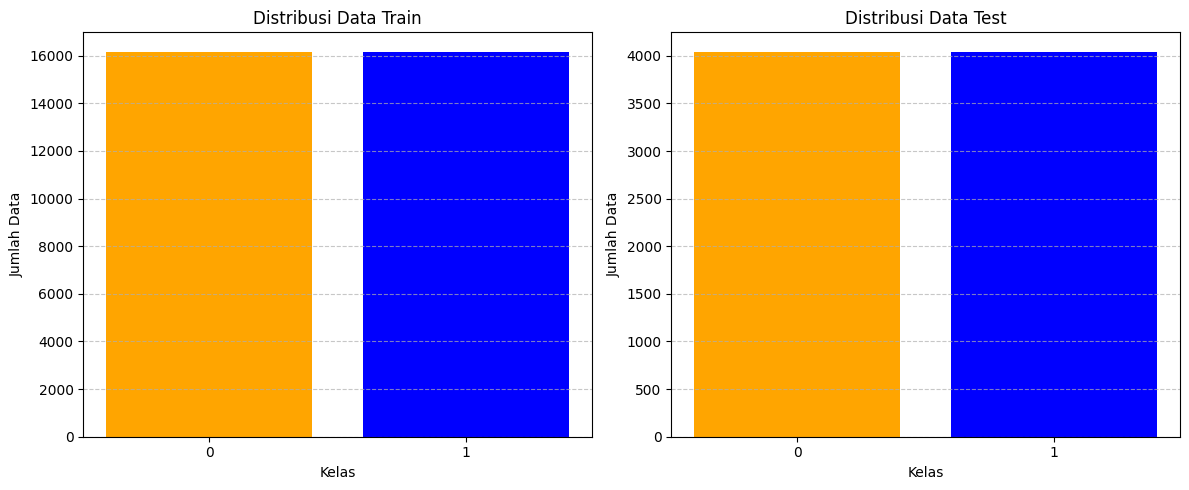

In [14]:
train_counts = Counter(y_train)
test_counts = Counter(y_test)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].bar(train_counts.keys(), train_counts.values(), color=['blue', 'orange'])
axes[0].set_title('Distribusi Data Train')
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['0', '1'])
axes[0].set_xlabel('Kelas')
axes[0].set_ylabel('Jumlah Data')
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

axes[1].bar(test_counts.keys(), test_counts.values(), color=['blue', 'orange'])
axes[1].set_title('Distribusi Data Test')
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['0', '1'])
axes[1].set_xlabel('Kelas')
axes[1].set_ylabel('Jumlah Data')
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## TF-IDF

In [15]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=30, max_df=0.90, strip_accents='unicode', sublinear_tf=True)
X_train_tfidf = vectorizer.fit_transform(X_train['cleaned_text'])
X_test_tfidf = vectorizer.transform(X_test['cleaned_text'])

In [16]:
print("Jumlah fitur yang diekstrak:", len(vectorizer.vocabulary_))

Jumlah fitur yang diekstrak: 10256


## Random Forest

In [17]:
@timeout_decorator.timeout(900, use_signals=False)
def train(n_estimators, max_depth, max_features, min_samples_split, min_samples_leaf):
    rf_model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        max_features=max_features,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    rf_model.fit(X_train_tfidf, y_train)
    return rf_model

def objective(trial):    
    n_estimators = trial.suggest_int("n_estimators", 50, 300)
    max_depth = trial.suggest_categorical("max_depth", [None] + list(range(5, 51)))
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)

    try:
        rf_model = train(n_estimators, max_depth, max_features, min_samples_split, min_samples_leaf)
        y_pred = rf_model.predict(X_test_tfidf)
        accuracy = accuracy_score(y_test, y_pred)
    except TimeoutError:
        raise optuna.exceptions.TrialPruned()
    return accuracy

In [18]:
# Hyperparameter Tuning
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
study.enqueue_trial({
    "n_estimators": 100,
    "max_depth": None,
    "max_features": "sqrt",
    "min_samples_split": 2,
    "min_samples_leaf": 1
})
study.optimize(objective, n_trials=50, n_jobs=4)

[I 2025-05-05 15:56:45,681] A new study created in memory with name: no-name-3a61957b-58d5-49e2-8278-5e988a5a8b53
[I 2025-05-05 15:56:58,862] Trial 3 finished with value: 0.8519846667491034 and parameters: {'n_estimators': 99, 'max_depth': 17, 'max_features': 'sqrt', 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 3 with value: 0.8519846667491034.
[I 2025-05-05 15:57:08,465] Trial 4 finished with value: 0.8857425497712378 and parameters: {'n_estimators': 181, 'max_depth': 31, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 4 with value: 0.8857425497712378.
[I 2025-05-05 15:57:38,813] Trial 2 finished with value: 0.882403858043774 and parameters: {'n_estimators': 197, 'max_depth': 49, 'max_features': 'sqrt', 'min_samples_split': 9, 'min_samples_leaf': 6}. Best is trial 4 with value: 0.8857425497712378.
[I 2025-05-05 15:57:56,612] Trial 6 finished with value: 0.8777049585754916 and parameters: {'n_estimators': 75, 'max_depth': 44, 'max_

In [19]:
print("Best parameters:", study.best_params)
print("Best accuracy:", study.best_value)

Best parameters: {'n_estimators': 248, 'max_depth': None, 'max_features': 'log2', 'min_samples_split': 4, 'min_samples_leaf': 2}
Best accuracy: 0.9114628415976258


In [20]:
# Re-training
best_params = study.best_params
rf_model = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    max_features=best_params['max_features'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42
)
start = time.time()
rf_model.fit(X_train_tfidf, y_train)
print(f"Training Time: {time.time() - start:.2f} s")

Training Time: 17.08 s


In [21]:
# Evaluation
rf_y_pred = rf_model.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, rf_y_pred)
print(f'Akurasi: {accuracy:.4f}')

precision_cg = precision_score(y_test, rf_y_pred)
print(f'Presisi (Fake Review): {precision_cg:.4f}')

recall_cg = recall_score(y_test, rf_y_pred)
print(f'Recall (Fake Review): {recall_cg:.4f}')

f1_cg = f1_score(y_test, rf_y_pred)
print(f'F1-Score (Fake Review): {f1_cg:.4f}')

Akurasi: 0.9115
Presisi (Fake Review): 0.9376
Recall (Fake Review): 0.8815
F1-Score (Fake Review): 0.9087


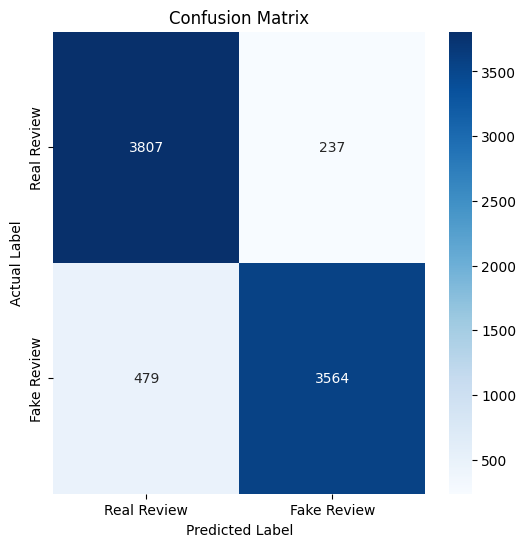

In [22]:
conf_matrix = confusion_matrix(y_test, rf_y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Real Review', 'Fake Review'], yticklabels=['Real Review', 'Fake Review'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

In [23]:
print("Classification Report:")
print(classification_report(y_test, rf_y_pred, target_names=['Real Review', 'Fake Review']))

Classification Report:
              precision    recall  f1-score   support

 Real Review       0.89      0.94      0.91      4044
 Fake Review       0.94      0.88      0.91      4043

    accuracy                           0.91      8087
   macro avg       0.91      0.91      0.91      8087
weighted avg       0.91      0.91      0.91      8087



## Save Model

In [24]:
joblib.dump(rf_model, '/kaggle/working/rf.pkl')

['/kaggle/working/rf.pkl']